In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
import scipy as sc
from scipy import random, linalg, stats, special

In [9]:
df = pd.read_csv("C:/bizanal/1_iris_virginica.csv")
df.head(n=5)

,sepallength,sepalwidth,petallength,petalwidth,label
0,5.1,3.5,1.4,0.2,outlier
1,4.9,3.0,1.4,0.2,outlier
2,4.7,3.2,1.3,0.2,outlier
3,4.6,3.1,1.5,0.2,outlier
4,5.0,3.6,1.4,0.2,outlier


In [10]:
#데이터를 matrix 형식으로 만들어 줌
y = pd.DataFrame.as_matrix(df[['sepallength','sepalwidth ','petallength','petalwidth ']])
y.shape
print(y[0:5])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]


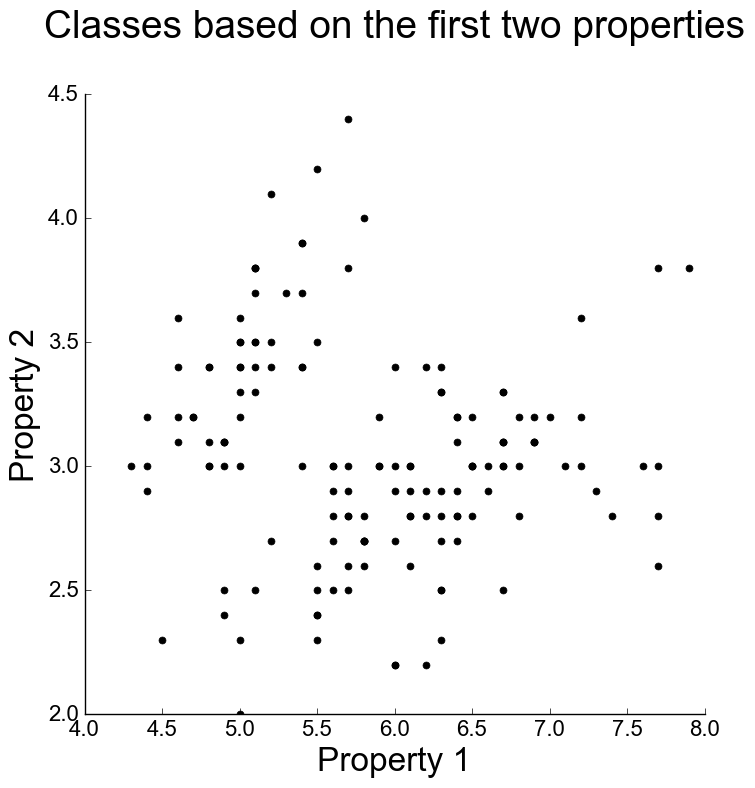

In [14]:
# 1열과 2열 데이터만 가지고 2차원 그래프 생성
plotsize = 8
sizeMean =10
text_size = 16
axis_font = {'fontname':'Arial', 'size':'24'}
Title_font= {'fontname':'Arial', 'size':'28'}
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y[:,0], y[:,1], 'k.', markersize= sizeMean)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('Classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize, plotsize)

plt.show()

In [15]:
y.shape

(150, 4)

In [16]:
#parameters
NProperties = y.shape[1] #variable의 갯수 
NClasses = 6             # 몇개의 class로 나눌것인가 , 가우시간 분포 갯수, Hyper parameter
NObjects = y.shape[0]    # 데이터의 행 데이터 갯수

In [19]:
# 초기 Mu, Cov 값 크기 설정
initMu = np.empty([NClasses, NProperties])
initCov = np.empty([NProperties, NProperties, NClasses])
print("initMu size =" ,initMu.shape)
print("initCov size =", initCov.shape)

initMu size = (6, 4)
initCov size = (4, 4, 6)


In [20]:
#sd 를 가지는 n*n 의 양의 matrix를 만들어 내는 함수 (초기값을 주기 위해 생성)
def PosSymDefMatrix(n,sd):
    M = np.matrix(np.random.rand(n,n))
    M = 0.5*(M + M.T)
    M = M + sd*np.eye(n)
    return M

In [24]:
Cov = [PosSymDefMatrix(NProperties,i) for i in range(0,NClasses)]
for j in range(NClasses):
    initMu[j, :] = np.random.random(NProperties) * np.amax(y, axis=0)
    initCov[:, :, j] = np.mean(np.array(Cov), axis=0) + 2
    
print("initMu=" ,initMu) # average
print("initCov=" ,initCov) # sigma
print("Cov=", Cov)
theta = np.repeat(1.0/NClasses,NClasses)

initMu= [[ 3.71612848  1.25346234  5.47292455  0.1651676 ]
 [ 0.6631407   1.11885043  2.33702313  1.90178206]
 [ 5.13365137  2.92768792  3.26079021  2.40695861]
 [ 0.19889381  0.03622022  1.35853645  0.75902367]
 [ 4.142285    3.8123626   1.5924712   2.07539611]
 [ 3.07713516  2.80455415  6.08098033  0.74167026]]
initCov= [[[ 5.06527956  5.06527956  5.06527956  5.06527956  5.06527956  5.06527956]
  [ 2.48299723  2.48299723  2.48299723  2.48299723  2.48299723  2.48299723]
  [ 2.51909173  2.51909173  2.51909173  2.51909173  2.51909173  2.51909173]
  [ 2.42408066  2.42408066  2.42408066  2.42408066  2.42408066  2.42408066]]

 [[ 2.48299723  2.48299723  2.48299723  2.48299723  2.48299723  2.48299723]
  [ 4.82348169  4.82348169  4.82348169  4.82348169  4.82348169  4.82348169]
  [ 2.54921792  2.54921792  2.54921792  2.54921792  2.54921792  2.54921792]
  [ 2.4871391   2.4871391   2.4871391   2.4871391   2.4871391   2.4871391 ]]

 [[ 2.51909173  2.51909173  2.51909173  2.51909173  2.51909173  

In [27]:
print ('각각 class의 가중치 확률 theta '+str(NClasses))
print (theta)
initW = theta

각각 class의 가중치 확률 theta 6
[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]


In [29]:
#EM Algorithm 구현 Expectation
def EStep(y, w, mu, cov): 
    r_ij = np.zeros((y.shape[0], mu.shape[0]))

    for Object in range(y.shape[0]):

        r_ij_Sumj = np.zeros(mu.shape[0])

        for jClass in range(mu.shape[0]):
            r_ij_Sumj[jClass] = w[jClass] * sc.stats.multivariate_normal.pdf(y[Object, :], mu[jClass, :],cov[:, :, jClass])

        for jClass in range(r_ij_Sumj.shape[0]):
            r_ij[Object, jClass] = r_ij_Sumj[jClass] / np.sum(r_ij_Sumj)

    return r_ij

r_n = EStep(y, initW, initMu, initCov)
print (r_n[0:5,:])

[[ 0.01149582  0.00901361  0.37731599  0.0115863   0.58188446  0.00870381]
 [ 0.01719346  0.01342368  0.42265304  0.01821461  0.51738291  0.0111323 ]
 [ 0.01332069  0.01427688  0.37667608  0.01859785  0.56688377  0.01024474]
 [ 0.01906105  0.01799441  0.39893405  0.023138    0.52612977  0.01474271]
 [ 0.01079858  0.009496    0.35940914  0.01190679  0.59945163  0.00893787]]


In [30]:
#EM Algorithm 구현 Maximazation
def MStep(r, y, mu, cov):
    N = y.shape[0]

    # the weigths , Estep의 평균
    w_j = np.sum(r, axis=0) / N

    Allmu_j = np.zeros((N, mu.shape[0], mu.shape[1]))
    Allcov_j = np.zeros((N, cov.shape[0], cov.shape[1], cov.shape[2]))

    # mean
    for Object in range(N):
        Allmu_j[Object, :, :] = np.outer(r[Object, :], y[Object, :])

    mu_j = np.zeros((mu.shape[0], mu.shape[1]))

    for j in range(cov.shape[2]):
        mu_j[j, :] = (1 / np.sum(r, axis=0)[j]) * np.sum(Allmu_j, axis=0)[j, :]

    # sd
    for Object in range(N):
        for j in range(cov.shape[2]):
            Allcov_j[Object, :, :, j] = r[Object, j] * np.outer((y[Object, :] - mu_j[j, :]),
                                                                (y[Object, :] - mu_j[j, :]))

    cov_j = np.zeros((cov.shape[0], cov.shape[1], cov.shape[2]))

    for j in range(cov.shape[2]):
        cov_j[:, :, j] = (1 / np.sum(r, axis=0)[j]) * np.sum(Allcov_j, axis=0)[:, :, j]

    return w_j, mu_j, cov_j

w_n,mu_n,cov_n = MStep(r_n, y, initMu, initCov)
print(w_n)
print(mu_n)
print(cov_n)

[ 0.192126    0.01449623  0.44709298  0.0150217   0.24302008  0.088243  ]
[[ 6.38483876  2.89663964  5.07044293  1.71864136]
 [ 5.64993857  2.92210409  3.76630909  1.2323379 ]
 [ 5.86734022  3.02020929  3.842016    1.24039876]
 [ 5.55519371  2.92902459  3.5077534   1.11008848]
 [ 5.24632944  3.30456819  2.15410698  0.53570873]
 [ 6.26767506  2.92069587  4.94071326  1.69044269]]
[[[ 0.51413253  0.50392999  0.61954602  0.50079733  0.35164397  0.500616  ]
  [ 0.09694456  0.0055463  -0.01755029 -0.01062037 -0.00275412  0.09214501]
  [ 0.60002175  0.91858786  1.11943256  0.9440548   0.6269164   0.61284864]
  [ 0.20947679  0.39509355  0.46442492  0.4010107   0.26508197  0.22626591]]

 [[ 0.09694456  0.0055463  -0.01755029 -0.01062037 -0.00275412  0.09214501]
  [ 0.11635076  0.16256961  0.17347938  0.17479494  0.20083959  0.11858274]
  [ 0.08532546 -0.19533042 -0.25274047 -0.24634826 -0.28923547  0.06722729]
  [ 0.05521391 -0.06813618 -0.09005831 -0.09107534 -0.11128262  0.04833065]]

 [[ 0.6

In [31]:
# implement EM algorithm
Inititeration = 100
EMiteration = 40
lookLH = 20

In [32]:
for init in range(Inititeration):

    # starting values
    initMu = np.empty([NClasses, NProperties])
    for j in range(NClasses):
        initMu[j, :] = np.random.random(NProperties) * np.amax(y, axis=0)

    r_n = EStep(y, initW, initMu, initCov)
    w_n, mu_n, cov_n = MStep(r_n, y, initMu, initCov)

    if init == 0:
        logLH = -1000000000000

    for i in range(EMiteration):

        # E step
        r_n = EStep(y, w_n, mu_n, cov_n)

        # M step
        w_n, mu_n, sigma_n = MStep(r_n, y, mu_n, cov_n)

        # log likelihood를 계산 
        logLall = np.zeros((y.shape[0]))

        for Object in range(y.shape[0]):

            LH = np.zeros(NClasses)

            for jClass in range(NClasses):
                LH[jClass] = w_n[jClass] * sc.stats.multivariate_normal.pdf(y[Object, :], mu_n[jClass, :],
                                                                            cov_n[:, :, jClass])

            logLall[Object] = np.log(np.sum(LH))

        logL = np.sum(logLall)

        if i > EMiteration - lookLH:
            print(logL)

    if logL > logLH:
        logLH = logL
        print('found larger: ', logLH)
        w_p = w_n
        mu_p = mu_n
        sigma_p = sigma_n
        r_p = r_n


-284.979345386
-284.282694335
-283.671810816
-283.128085095
-282.634496153
-282.175832566
-281.738602203
-281.311010972
-280.884056927
-280.455616233
-280.037880321
-279.6582529
-279.338241592
-279.074568509
-278.849382178
-278.64460664
-278.450623414
-278.264417159
-278.085404376
found larger:  -278.085404376
-305.729260561
-305.664006008
-305.604660357
-305.549341099
-305.496998956
-305.446921732
-305.398584248
-305.351590382
-305.305640843
-305.260510784
-305.216032959
-305.172084728
-305.128577956
-305.085451151
-305.042663321
-305.000189183
-304.958015424
-304.916137784
-304.874558788
-318.918514964
-318.841098901
-318.772110905
-318.71048074
-318.655293362
-318.605763938
-318.561217378
-318.521071363
-318.484822205
-318.45203301
-318.422323752
-318.395362928
-318.370860538
-318.348562154
-318.328243918
-318.30970831
-318.292780552
-318.277305565
-318.263145375
-315.00132951
-314.971090882
-314.950142527
-314.935625285
-314.925340367
-314.917450141
-314.910917235
-314.90528265
-31

In [34]:
print ("mu=", mu_n)
print("sigma=",cov_n)

mu= [[ 4.59464809  2.31562988  1.54092181  0.39155671]
 [ 7.39286977  2.74189742  6.27644052  2.01809329]
 [ 7.71363827  3.70260765  6.46457857  2.06410392]
 [ 5.18895343  2.40514222  3.13410609  0.92273886]
 [ 5.03051691  3.40486927  1.55034115  0.27791037]
 [ 6.24384555  2.86123901  4.89275743  1.67704889]]
sigma= [[[ 0.51397212  0.55790838  0.54827127  0.44792063  0.23475623  0.43699685]
  [-0.03559177  0.05277998  0.06872262 -0.03237151  0.04135434  0.0976964 ]
  [ 1.00621045  0.83159123  0.76397147  0.86431197  0.33596003  0.46645215]
  [ 0.42064147  0.32880289  0.29224599  0.35926615  0.14394048  0.17016048]]

 [[-0.03559177  0.05277998  0.06872262 -0.03237151  0.04135434  0.0976964 ]
  [ 0.19406212  0.1341039   0.12714641  0.20665351  0.18037014  0.10799377]
  [-0.33784396 -0.03739476  0.00496765 -0.36170788 -0.17510713  0.09943192]
  [-0.12944259  0.00385039  0.02118111 -0.13922714 -0.06523053  0.06724132]]

 [[ 1.00621045  0.83159123  0.76397147  0.86431197  0.33596003  0.4664

In [39]:
# 판정
mul_pdf =np.zeros(NClasses)
tot=0
for i in range(0, y.shape[0]):
    n = 0
    b = 0
    for jClass in range(0,NClasses):
        mul_pdf[jClass] = sc.stats.multivariate_normal.pdf(y[i, :], mu_p[jClass, :],sigma_p[:, :, jClass])
        if mul_pdf[jClass] > 0.025 and mul_pdf[jClass] < 0.975:
            n=n+1
        else:
            b =b+1
    if n==0:
        tot = tot+1
        print("abnormal =", y[i,:])
print("abnormal count=", tot)
print("normal count =" ,y.shape[0]-tot)

abnormal = [ 5.1  3.5  1.4  0.2]
abnormal = [ 4.7  3.2  1.3  0.2]
abnormal = [ 4.6  3.1  1.5  0.2]
abnormal = [ 5.   3.6  1.4  0.2]
abnormal = [ 5.4  3.9  1.7  0.4]
abnormal = [ 4.6  3.4  1.4  0.3]
abnormal = [ 5.   3.4  1.5  0.2]
abnormal = [ 4.4  2.9  1.4  0.2]
abnormal = [ 4.9  3.1  1.5  0.1]
abnormal = [ 5.4  3.7  1.5  0.2]
abnormal = [ 4.8  3.4  1.6  0.2]
abnormal = [ 4.8  3.   1.4  0.1]
abnormal = [ 5.1  3.5  1.4  0.3]
abnormal = [ 5.7  3.8  1.7  0.3]
abnormal = [ 5.1  3.8  1.5  0.3]
abnormal = [ 5.4  3.4  1.7  0.2]
abnormal = [ 5.1  3.7  1.5  0.4]
abnormal = [ 5.1  3.3  1.7  0.5]
abnormal = [ 5.   3.   1.6  0.2]
abnormal = [ 5.   3.4  1.6  0.4]
abnormal = [ 5.2  3.5  1.5  0.2]
abnormal = [ 5.2  3.4  1.4  0.2]
abnormal = [ 4.7  3.2  1.6  0.2]
abnormal = [ 4.8  3.1  1.6  0.2]
abnormal = [ 5.4  3.4  1.5  0.4]
abnormal = [ 5.5  4.2  1.4  0.2]
abnormal = [ 4.9  3.1  1.5  0.1]
abnormal = [ 5.   3.2  1.2  0.2]
abnormal = [ 4.9  3.1  1.5  0.1]
abnormal = [ 4.4  3.   1.3  0.2]
abnormal =

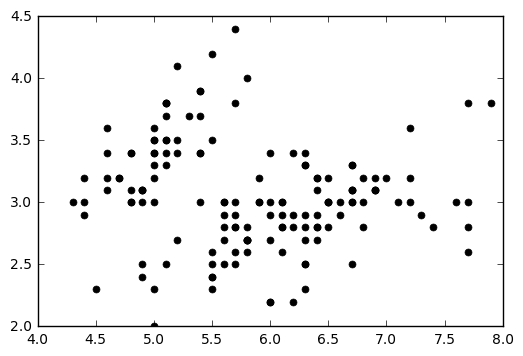

In [37]:
#gaussian plot
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname': 'Arial', 'size': '24'}
Title_font = {'fontname': 'Arial', 'size': '28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=sizeMean)


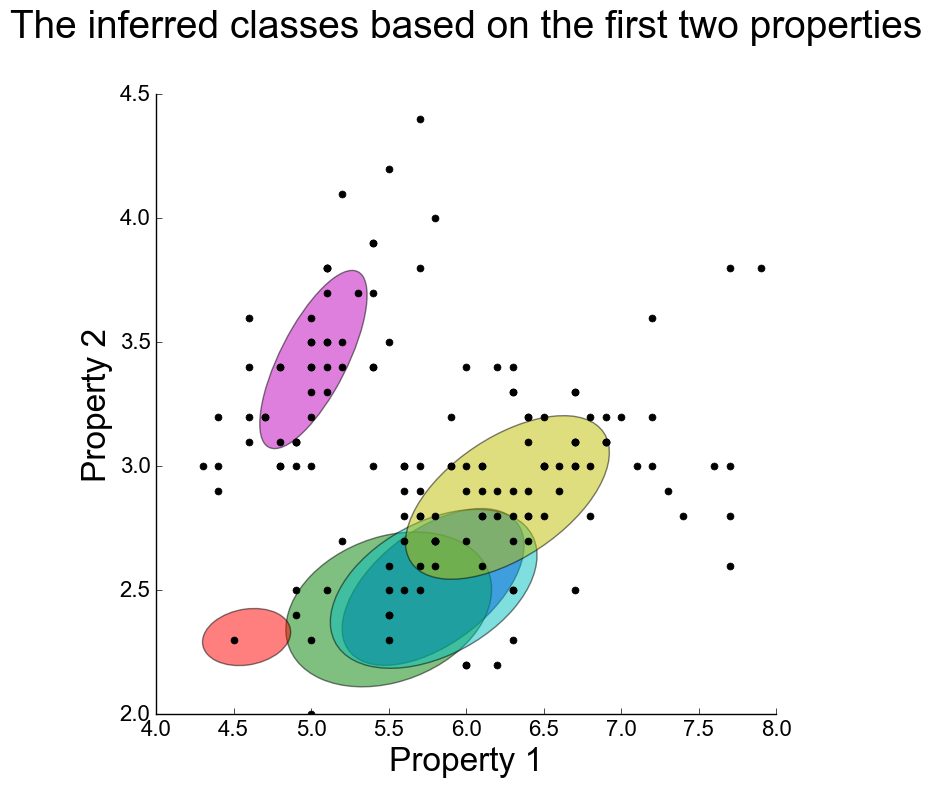

In [38]:
#gaussian plot
# plot parameters
plotsize = 8
sizeMean = 10
text_size = 16
axis_font = {'fontname': 'Arial', 'size': '24'}
Title_font = {'fontname': 'Arial', 'size': '28'}
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=sizeMean)

for i in range(NClasses):
    # the sd with ellipses
    # central point of the error ellipse
    pos = [mu_p[i, 0], mu_p[i, 1]]

    # for the angle we need the eigenvectors of the covariance matrix
    w, ve = np.linalg.eig(sigma_p[0:2, 0:2, i])

    # We pick the largest eigen value
    order = w.argsort()[::-1]
    w = w[order]
    ve = ve[:, order]

    # we compute the angle towards the eigen vector with the largest eigen value
    thetaO = np.degrees(np.arctan(ve[1, 0] / ve[0, 0]))

    # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
    width, height = 2 * np.sqrt(w)

    # making the ellipse
    ellip = Ellipse(xy=pos, width=width, height=height, angle=thetaO)
    ellip.set_alpha(0.5)
    ellip.set_facecolor(color[i])

    ax.add_artist(ellip)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(text_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Property 2', **axis_font)
ax.set_xlabel('Property 1', **axis_font)
ax.set_title('The inferred classes based on the first two properties', y=1.08, **Title_font)
ax.figure.set_size_inches(plotsize, plotsize)

plt.show()